In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

from helpers.utils import model, weights_public_sample, safe_dir_draw, toy_plot_for_mean_mixture, multivariate_mean_iterative, L2

import warnings
warnings.filterwarnings("ignore")

## Stylized Stratified Coinpress Example
The begining of this notebook demonstrates the use of the stratified coinpress algorithm on a stylized example.

The example is a mixture of Gaussians, each with a different mean. The data is then stratified into k groups.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


        X
G        
0.0   639
1.0   504
2.0  8857


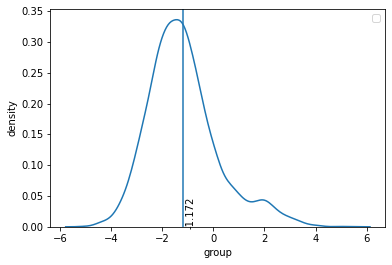

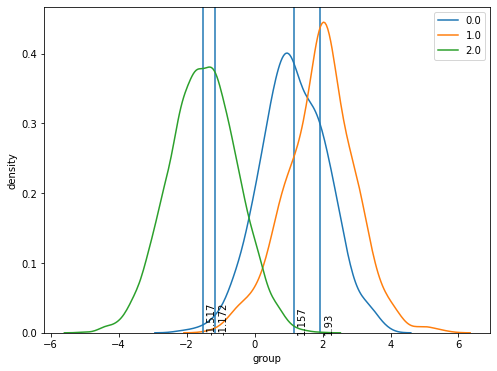

In [2]:
toy_plot_for_mean_mixture()

In [3]:
from tqdm import tqdm
import os
from utils import add_to_results_df, weighted_mean
import pickle

if os.path.exists('results_df.pkl'):
    results_df = pd.read_pickle('results_df.pkl')
else:
    use_weights = True

    p = 0.5
    Ps2 = [(1.0/4.0)*p, (3.0/4.0)*p]

    errors = {
        'Coinpress': [],
        'StratCoinpress': [],
        'StratCoinpressPublic': []
    }

    ns = [2000, 4000, 6000, 8000, 10000]
    alphas = [3.0, 10.0] #, [0.3, 0.7, 1.0]
    ks = [3, 6, 12]
    pub_sample_prop = 0.5

    # results_df = pd.DataFrame(columns=['n', 'error', 'std', 'method', 'alpha', 'k'])
    for n in tqdm(ns):
        n = int(n * (1/pub_sample_prop))
        for alpha in tqdm(alphas):
            for k in tqdm(ks):
                coinpress_overall_means = []
                group_overall_means = []
                group_overall_means_public = []
                for i in range(10):
                    df = model(n=n, seed=i, alpha=alpha, k=k)
                    df, weights = weights_public_sample(df, pub_sample_prop)
                    overall_mean = np.mean(df.X)

                    coinpress_mean = multivariate_mean_iterative(df.X.values.reshape(-1,1), 0, 3, 2, Ps2)
                    coinpress_overall_means.append(L2(overall_mean-coinpress_mean))
                    
                    group_means = []
                    for group in df.G.unique():
                        group_frame = df.X[df.G == group]
                        group_mean = np.mean(group_frame)
                        coinpress_group_mean = multivariate_mean_iterative(group_frame.values.reshape(-1,1), 0, 3, 2, Ps2)
                        group_means.append((group_mean, len(group_frame), group))

                    group_overall_means.append(L2(overall_mean-weighted_mean(group_means, len(df), use_weights=False, verbose=False)))
                    group_overall_means_public.append(L2(overall_mean-weighted_mean(group_means, len(df), weights=weights, use_weights=True, verbose=False)))

                for method, mean_values in zip(['Coinpress', 'StratCoinpress', 'StratCoinpressPublic'], [coinpress_overall_means, group_overall_means, group_overall_means_public]):
                    mean, std = np.mean(mean_values), np.std(mean_values)
                    errors[method].append((mean, std))
                    results_df = add_to_results_df(results_df, n, mean, std, method, alpha, k)

    with open('results_df.pkl', 'wb') as f:
        pickle.dump(results_df, f)

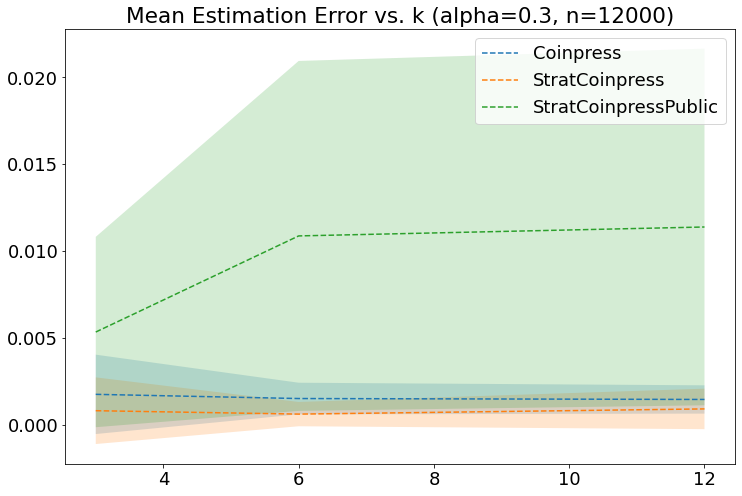

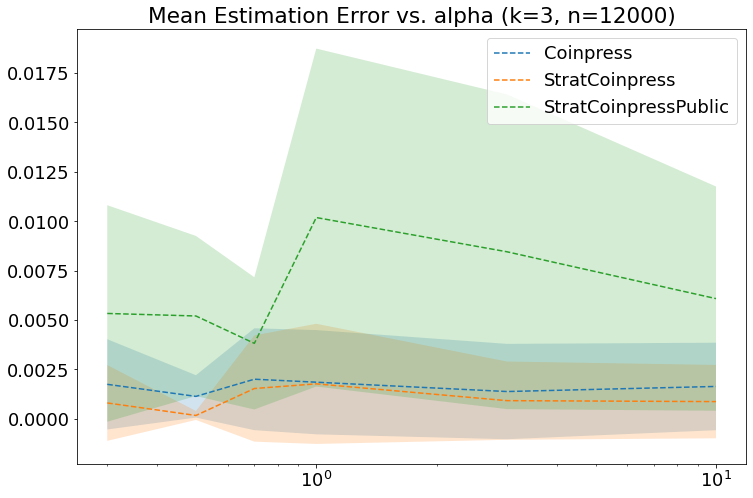

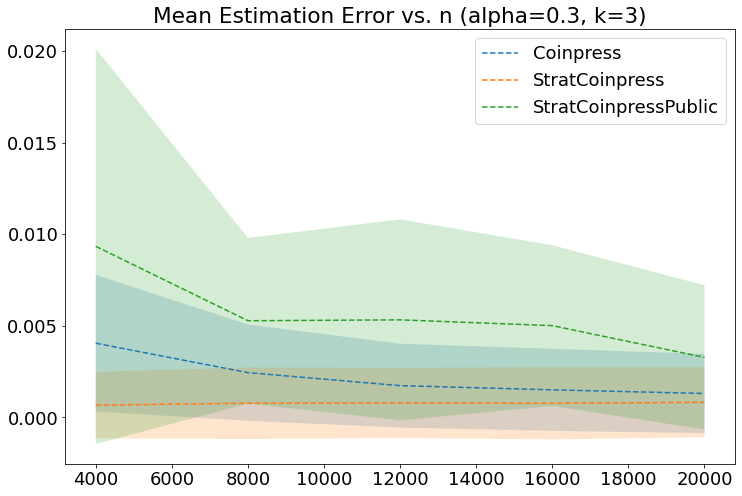

In [326]:
import seaborn as sns
import matplotlib.pyplot as plt
# from utils import plot_error_vs_alpha, plot_error_vs_k, plot_error_vs_n
def plot_error_vs_k(results_df, alpha, n):
    df_filtered = results_df[(results_df['alpha'] == alpha) & (results_df['n'] == n)]
    df_filtered[['error', 'std', 'k']] = df_filtered[['error', 'std', 'k']].apply(pd.to_numeric)
    plt.figure(figsize=(12, 8))
    for method in df_filtered['method'].unique():
        method_data = df_filtered[df_filtered['method'] == method]
        plt.plot(method_data['k'], method_data['error'], '--', label=method)
        plt.fill_between(method_data['k'], method_data['error'] - method_data['std'], method_data['error'] + method_data['std'], alpha=0.2)
    plt.title(f'Mean Estimation Error vs. k (alpha={alpha}, n={n})')
    plt.legend()
    plt.rcParams.update({'font.size': 18})
    plt.show()

def plot_error_vs_alpha(results_df, k, n):
    df_filtered = results_df[(results_df['k'] == k) & (results_df['n'] == n)]
    df_filtered[['error', 'std', 'alpha']] = df_filtered[['error', 'std', 'alpha']].apply(pd.to_numeric)
    plt.figure(figsize=(12, 8))
    for method in df_filtered['method'].unique():
        method_data = df_filtered[df_filtered['method'] == method]
        plt.plot(method_data['alpha'], method_data['error'], '--', label=method)
        plt.fill_between(method_data['alpha'], method_data['error'] - method_data['std'], method_data['error'] + method_data['std'], alpha=0.2)
    plt.title(f'Mean Estimation Error vs. alpha (k={k}, n={n})')
    # log x axis
    plt.xscale('log')
    plt.legend()
    plt.rcParams.update({'font.size': 18})
    plt.show()

def plot_error_vs_n(results_df, alpha, k):
    df_filtered = results_df[(results_df['alpha'] == alpha) & (results_df['k'] == k)]
    df_filtered[['error', 'std', 'n']] = df_filtered[['error', 'std', 'n']].apply(pd.to_numeric)
    plt.figure(figsize=(12, 8))
    for method in df_filtered['method'].unique():
        method_data = df_filtered[df_filtered['method'] == method]
        plt.plot(method_data['n'], method_data['error'], '--', label=method)
        plt.fill_between(method_data['n'], method_data['error'] - method_data['std'], method_data['error'] + method_data['std'], alpha=0.2)
    plt.title(f'Mean Estimation Error vs. n (alpha={alpha}, k={k})')
    plt.legend()
    plt.rcParams.update({'font.size': 18})
    plt.show()
plot_error_vs_k(results_df, alpha=0.3, n=12000)
plot_error_vs_alpha(results_df, k=3, n=12000)
plot_error_vs_n(results_df, alpha=0.3, k=3)

### Advanced plotting for evaluating two metrics at once

This function creates a grid of bar plots, where each row corresponds to a unique value of k, and each column corresponds to a unique value of alpha. The x-axis represents different values of n, and the y-axis shows the error. The alpha_list parameter allows you to specify which alpha values to include in the plot. If you want to include all possible alpha values, you can pass results_df['alpha'].unique() as the alpha_list argument.

You can modify the function to display other combinations of factors by changing the col, row, and x parameters. For example, if you want to combine alpha and n in a single plot with different values of k as separate columns, you can swap the col, row, and x parameters like this:

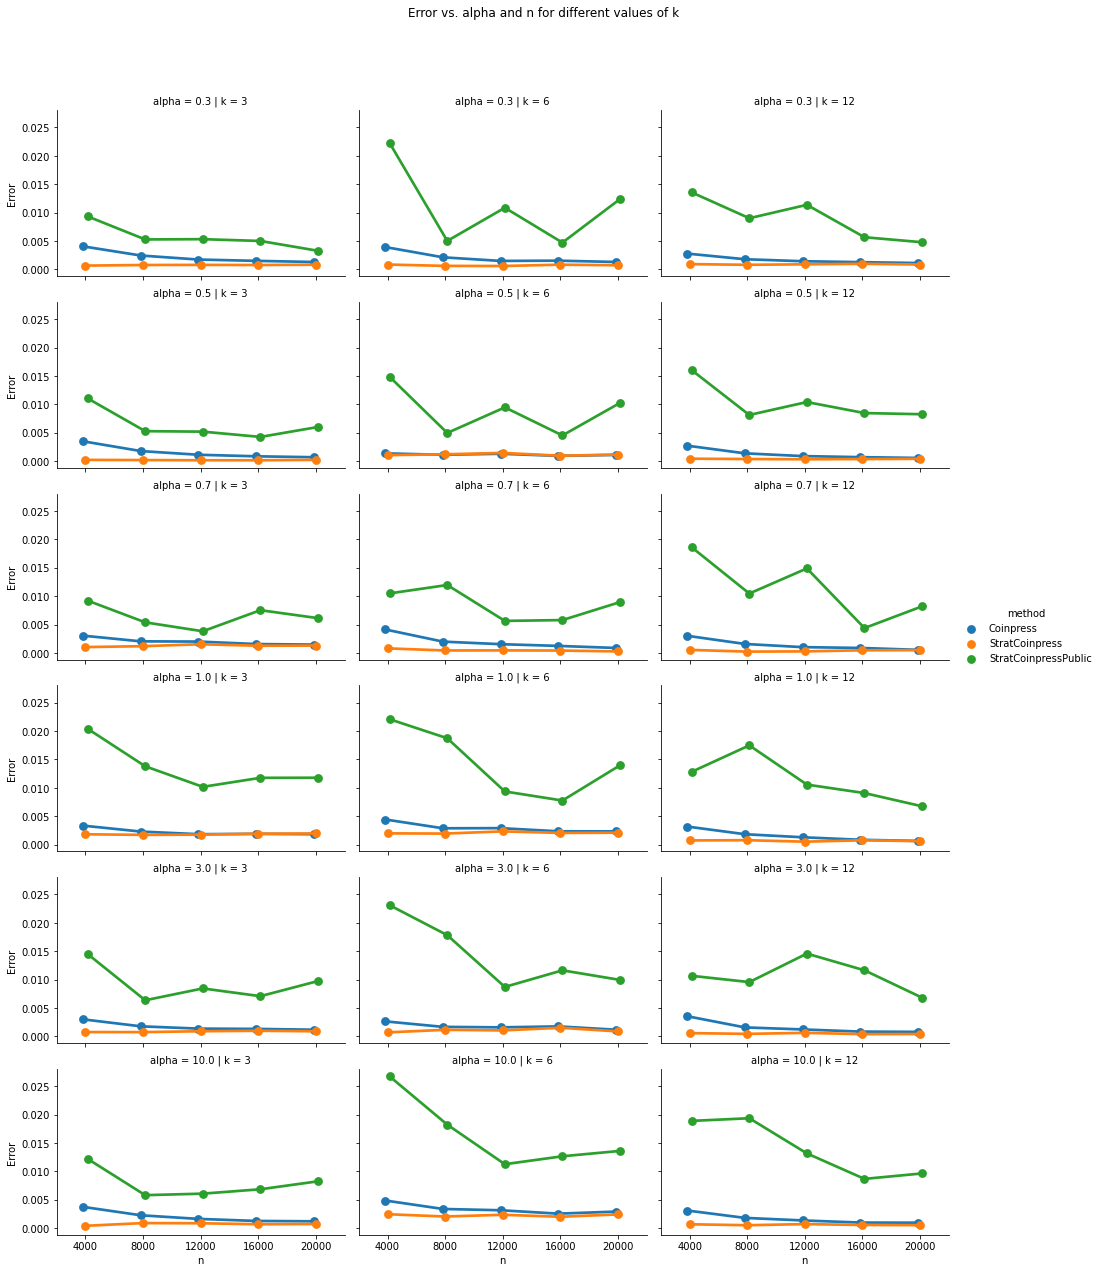

In [5]:
from utils import plot_error_vs_alpha_and_n

k_list = [3, 6, 12]
plot_error_vs_alpha_and_n(results_df, k_list)

## Stratified Coinpress on Folktables (ACS Community Survey)
The second part of this notebook demonstrates the use of the stratified coinpress algorithm on the ACS Community Survey data.

In [6]:
import pandas as pd
import numpy as np

from stratified_dataset import StratifiedDataset
from data_utils import get_public
import sqlite3
all_data = get_public()

In [40]:
df = all_data[['SEX',
                'DIS',
                'NATIVITY',
                'RAC1P',
                'AGEP', 
                # For measuring
                'SCHL',
                'WKHP',
                'JWMNP',
                'PINCP']]

# Please bin AGEP into 5 bins
df['AGEP'] = pd.cut(df['AGEP'], bins=5, labels=False)

# Randomly shuffle the indices of the dataframe
shuffled_indices = np.random.permutation(df.index)

# Split the shuffled dataframe into two equal parts
half = len(df) // 2
public_df = df.iloc[shuffled_indices[half:]]
df = df.iloc[shuffled_indices[:half]]

In [125]:
import itertools
from tqdm import tqdm
import pickle
import os

# List of column names you want to use
cols = ['SEX', 'DIS', 'NATIVITY', 'RAC1P', 'AGEP']

# Generate all possible combinations of the given column names
combinations = []
for i in range(1, len(cols) + 1):
    combinations.extend(list(itertools.combinations(cols, i)))

print(len(combinations))
# check if stratified_datasets.pkl exists
# if not, create it
if os.path.exists('stratified_datasets.pkl'):
    with open('stratified_datasets.pkl', 'rb') as f:
        stratified_datasets = pickle.load(f)
    with open('public_stratified_datasets.pkl', 'rb') as f:
        public_stratified_datasets = pickle.load(f)
else:
    # Create a list to store stratified datasets for each combination
    stratified_datasets = []
    public_stratified_datasets = []
    for combination in tqdm(combinations):
        strata_cols = list(combination)

        # Create a stratified dataset for the current combination
        stratified_data = StratifiedDataset(df, strata_cols)

        # Store the stratified dataset in the list
        stratified_datasets.append(stratified_data)
        
        public_stratified_data = StratifiedDataset(public_df, strata_cols)
        public_stratified_datasets.append(public_stratified_data)

    with open('stratified_datasets.pkl', 'wb') as f:
        pickle.dump(stratified_datasets, f)
    with open('public_stratified_datasets.pkl', 'wb') as f:
        pickle.dump(public_stratified_datasets, f)
    # Now stratified_datasets contains stratified datasets for each combination of column names

31


In [160]:
# for each combination
# Initialize a dictionary to store the number of unique values for each combination
verbose = False
unique_values_counts = {}

# Iterate through each combination
for combination in combinations:
    # Get the number of unique values for each group and store it in the dictionary
    unique_values_counts[str(combination).replace(",","")] = len(df[(df['combination'] == str(combination).replace(",","")) & (df['stratum_id'] != 'overall')]['stratum_id'].unique())

# Print the results
if verbose:
    for combination, count in unique_values_counts.items():
        print(f"Combination: {', '.join(combination)} - Unique Values: {count}")

In [258]:
import sqlite3
from utils import multivariate_mean_iterative, L2

# Assuming you've already imported the required libraries and defined the Coinpress function
# import necessary libraries for Coinpress here
# from coinpress import multivariate_mean_iterative

# Create a connection to the SQLite3 database
conn = sqlite3.connect('stratified_data_means.db')
cursor = conn.cursor()

# Create a table to store the mean values
cursor.execute('''
CREATE TABLE IF NOT EXISTS means (
    combination TEXT,
    stratum_id TEXT,
    column_name TEXT,
    mean_value REAL,
    mean_type TEXT,
    method TEXT,
    exact_data_size INTEGER,
    public_data_size INTEGER
)
''')

# Coinpress mean params     
p = 0.5
Ps2 = [(1.0/4.0)*p, (3.0/4.0)*p]
mean_apriori = {
    'SCHL': (12, 12),
    'WKHP': (40, 80),
    'JWMNP': (30, 100),
    'PINCP': (40000, 1000000)
}


# Function to calculate the mean for each column overall and for each stratum
def store_means_in_database(stratified_data, public_stratified_data, combination):
    overall_means = stratified_data.df.mean()
    strata_dfs = stratified_data.get_strata_dfs(limit_size=True)
    public_strata_dfs = public_stratified_data.get_strata_dfs(limit_size=True)
    remaining_columns = ['SCHL', 'WKHP', 'JWMNP', 'PINCP']

    for column_name in remaining_columns:
        overall_mean = overall_means[column_name]
        # remove null or nan from the a numpy array
        vals = stratified_data.df[column_name].values
        vals = vals[~np.isnan(vals)]
        public_vals = public_stratified_data.df[column_name].values
        public_vals = public_vals[~np.isnan(public_vals)]
        data_size = len(vals)
        public_data_size = len(public_vals)
        overall_mean_coinpress = multivariate_mean_iterative(vals.reshape(-1, 1), mean_apriori[column_name][0], mean_apriori[column_name][1], 2, Ps2)
        # print(stratified_data.df[column_name].values.reshape(-1, 1), mean_apriori[column_name][0], mean_apriori[column_name][1], 2, Ps2)
        # Store overall mean for the current column using standard and Coinpress methods
        cursor.execute('''
        INSERT INTO means (combination, stratum_id, column_name, mean_value, mean_type, method, exact_data_size, public_data_size)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', (str(combination).replace(",", ""), 'overall', column_name, overall_mean, 'overall', 'standard', data_size, public_data_size))

        cursor.execute('''
        INSERT INTO means (combination, stratum_id, column_name, mean_value, mean_type, method, exact_data_size, public_data_size)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', (str(combination).replace(",", ""), 'overall', column_name, overall_mean_coinpress[0], 'overall', 'coinpress', data_size, public_data_size))

        # Calculate and store mean for each stratum for the current column using standard and Coinpress methods
        for strata_df, public_strata_df in zip(strata_dfs, public_strata_dfs):
            mean_value = strata_df[column_name].mean()

            strata_vals = strata_df[column_name].values
            strata_vals = strata_vals[~np.isnan(strata_vals)]
            strata_data_size = len(strata_vals)

            public_strata_df = public_strata_df[column_name].values
            public_strata_df = public_strata_df[~np.isnan(public_strata_df)]
            public_strata_data_size = len(public_strata_df)

            if len(strata_vals) == 0:
                continue
            
            mean_value_coinpress = multivariate_mean_iterative(strata_vals.reshape(-1, 1), mean_apriori[column_name][0], mean_apriori[column_name][1], 2, Ps2)
            # print(mean_value_coinpress)
            stratum_identifier = '-'.join([f'{col}={row[col]}' for col in combination for _, row in strata_df.head(1).iterrows()])

            cursor.execute('''
            INSERT INTO means (combination, stratum_id, column_name, mean_value, mean_type, method, exact_data_size, public_data_size)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
            ''', (str(combination).replace(",", ""), stratum_identifier, column_name, mean_value, 'stratum', 'standard', strata_data_size, public_strata_data_size))

            cursor.execute('''
            INSERT INTO means (combination, stratum_id, column_name, mean_value, mean_type, method, exact_data_size, public_data_size)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
            ''', (str(combination).replace(",", ""), stratum_identifier, column_name, mean_value_coinpress[0], 'stratum', 'coinpress', strata_data_size, public_strata_data_size))

    # Commit the changes to the database
    conn.commit()

# Iterate through stratified_datasets and store the means in the SQLite3 database
for stratified_data, pub_strat_data, combination in zip(stratified_datasets, public_stratified_datasets, combinations):
    store_means_in_database(stratified_data, pub_strat_data, combination)

# Close the connection to the SQLite3 database
conn.close()

In [259]:
# load stratified_data_means.db into a pandas dataframe
conn = sqlite3.connect('stratified_data_means.db')
df = pd.read_sql_query("SELECT * FROM means", conn)
conn.close()

In [305]:
def weighted_means(mean_values, exact_data_size, public_data_size):
    return np.average(mean_values, weights=exact_data_size), np.average(mean_values, weights=public_data_size)

verbose = False

# Create a connection to the SQLite3 database
conn = sqlite3.connect('stratified_data_means.db')

# Define the list of remaining columns to calculate the means for
target_columns = ['SCHL', 'WKHP', 'JWMNP', 'PINCP']

# Create an empty dataframe to store the results

res_df = pd.DataFrame(columns=['combination','column_name', 'strat_coinpress', 'strat_coinpress_public'])
# Iterate through each combination and calculate the overall mean for each one
for combination in combinations:
    # Filter the mean values to only include the current combination
    filtered_means_df = df[df['combination'] == str(combination).replace(",", "")]
    
    # Calculate the stratum means for each column separately using weighted_mean
    filtered_means_df[(filtered_means_df['mean_type'] == 'stratum') & (filtered_means_df['method'] == 'coinpress')]
    
    # HERE: calculate weighted mean and store in stratum_means
    for column_name in filtered_means_df['column_name'].unique():
        just_column_df = filtered_means_df[(filtered_means_df['column_name'] == column_name) & 
                                            (filtered_means_df['method'] == 'coinpress') &
                                            (filtered_means_df['mean_type'] == 'stratum')]
        strat_coinpress, strat_coinpress_public = weighted_means(just_column_df['mean_value'], just_column_df['exact_data_size'], just_column_df['public_data_size'])
        res_df = res_df.append({'combination': combination, 
                                'column_name': column_name, 
                                'strat_coinpress': strat_coinpress, 
                                'strat_coinpress_public': strat_coinpress_public}, ignore_index=True)

# Add column to res_df for the overall means for each column name
res_df['standard'] = df[(df['stratum_id'] == 'overall') & (df['method'] == 'standard')]['mean_value'].values
res_df['coinpress'] = df[(df['stratum_id'] == 'overall') & (df['method'] == 'coinpress')]['mean_value'].values

# for res_df, calculate the difference between strat_coinpress and standard, strat_coinpress_public and standard, coinpress and standard
res_df['strat_coinpress_diff'] = abs(res_df['strat_coinpress'] - res_df['standard'])
res_df['strat_coinpress_public_diff'] = abs(res_df['strat_coinpress_public'] - res_df['standard'])
res_df['coinpress_diff'] = abs(res_df['coinpress'] - res_df['standard'])

res_df['size_of_combination'] = res_df['combination'].apply(lambda x: unique_values_counts[str(x).replace(",", "")])


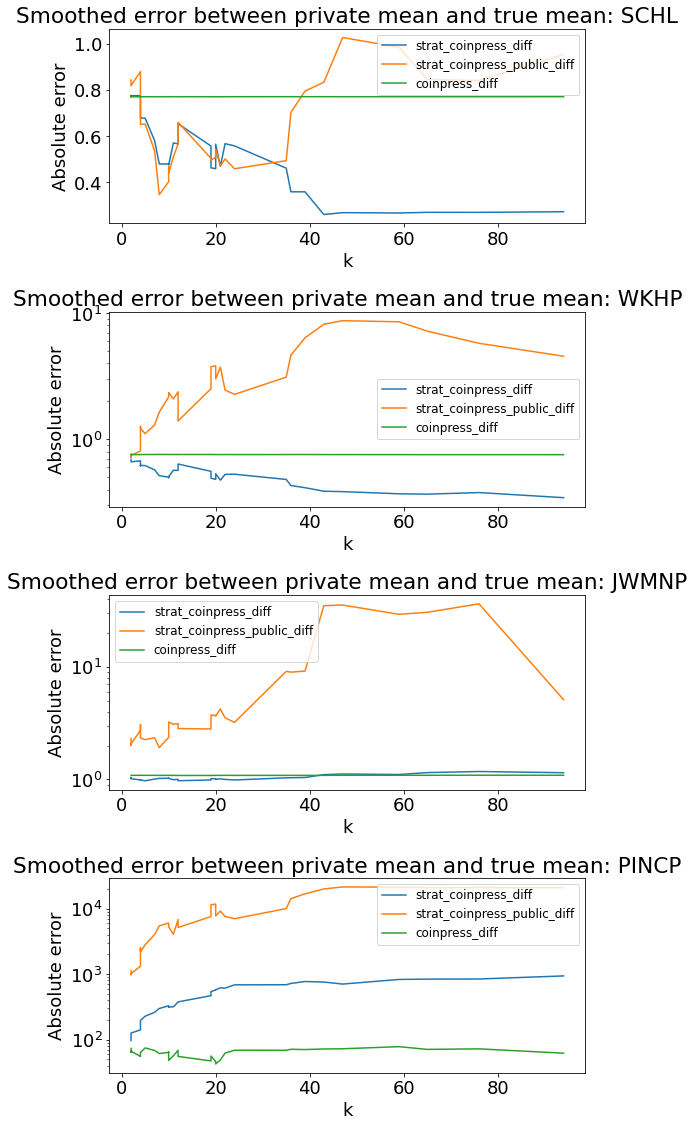

In [309]:
import matplotlib.pyplot as plt

# Define the number of rows and columns for the subplots
nrows = 4
ncols = (len(target_columns) + 1) // nrows

# Create the subplots with the specified number of rows and columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 16))

# Iterate through the target_columns and their corresponding axes
for target, ax in zip(target_columns, axes.flatten()):
    #grouped_data = res_df[res_df['column_name'] == target].groupby('size_of_combination').mean()
    grouped_data = res_df[res_df['column_name'] == target]
    grouped_data = grouped_data.sort_values(by=['size_of_combination'])
    window_size = 5

    # Calculate the rolling average
    grouped_data['strat_coinpress_diff'] = grouped_data['strat_coinpress_diff'].rolling(window=window_size, center=True, min_periods=1).mean()
    grouped_data['strat_coinpress_public_diff'] = grouped_data['strat_coinpress_public_diff'].rolling(window=window_size, center=True, min_periods=1).mean()
    grouped_data['coinpress_diff'] = grouped_data['coinpress_diff'].rolling(window=window_size, center=True, min_periods=1).mean()

    # Reset the index to make the 'x' column a regular column again
    grouped_data = grouped_data.reset_index()

    # Plot the data using the current axis
    grouped_data.plot(x='size_of_combination', y=['strat_coinpress_diff', 'strat_coinpress_public_diff', 'coinpress_diff'], kind='line', ax=ax)
    
    # Set log y scale
    if target != 'SCHL':
        ax.set_yscale('log')
    
    # Set plot title
    ax.set_title(f'Smoothed error between private mean and true mean: {target}')
    ax.set_xlabel('k')
    ax.set_ylabel('Absolute error')
    # rename legend
    ax.legend(['strat_coinpress', 'strat_coinpress_public', 'coinpress'])
    # shrink legend font
    ax.legend(prop={'size': 12})

# Remove empty subplots if the total number of subplots is greater than the number of target_columns
for i in range(len(target_columns), nrows * ncols):
    fig.delaxes(axes.flatten()[i])

# Adjust the layout of the subplots
plt.tight_layout()
plt.rcParams.update({'font.size': 18})

# Show the plot
plt.show()

## Calculate the disparate impact of the overall coinpress


In [270]:
import sqlite3
import pandas as pd

def append_error_data(errors, combination, stratum_id, column_name, method, error, exact_data_size, public_data_size, mean_type):
    errors.append({
        'combination': combination,
        'stratum_id': stratum_id,
        'column_name': column_name,
        'method': method,
        'error': error,
        'exact_data_size': exact_data_size,
        'public_data_size': public_data_size,
        'mean_type': mean_type
    })

# Create a connection to the SQLite3 database
conn = sqlite3.connect('stratified_data_means.db')

# Query the SQLite3 database to get the mean values for each stratum and method
mean_data = pd.read_sql_query('''
SELECT combination, stratum_id, column_name, mean_value, mean_type, method, exact_data_size, public_data_size
FROM means
''', conn)

# Close the connection to the SQLite3 database
conn.close()

# Calculate the error between each "method" and the true mean (where "method"="standard") for each stratum and overall mean
errors = []

for (combination, column_name), group in mean_data.groupby(['combination', 'column_name']):
    overall_coinpress_mean_row = group.loc[(group['mean_type'] == 'overall') & (group['method'] == 'coinpress'), :]
    if not overall_coinpress_mean_row.empty:
        overall_coinpress_mean = overall_coinpress_mean_row['mean_value'].values[0]
        for stratum_id, stratum_group in group.groupby('stratum_id'):
            true_mean_row = stratum_group.loc[(stratum_group['method'] == 'standard') & (stratum_group['mean_type'] == 'stratum'), :]
            coinpress_mean_row = stratum_group.loc[(stratum_group['method'] == 'coinpress') & (stratum_group['mean_type'] == 'stratum'), :]
            if not true_mean_row.empty and not coinpress_mean_row.empty:
                true_mean = true_mean_row['mean_value'].values[0]
                coinpress_mean = coinpress_mean_row['mean_value'].values[0]
                error_stratum_coinpress = abs(coinpress_mean - true_mean)
                error_overall_coinpress = abs(overall_coinpress_mean - true_mean)

                exact_data_size = true_mean_row['exact_data_size'].values[0]
                public_data_size = true_mean_row['public_data_size'].values[0]

                append_error_data(errors, combination, stratum_id, column_name, 'coinpress', error_overall_coinpress, exact_data_size, public_data_size, 'coinpress')
                append_error_data(errors, combination, stratum_id, column_name, 'coinpress', error_stratum_coinpress, exact_data_size, public_data_size, 'stratified_coinpress')

# Create a DataFrame to store the aggregated error data
error_df = pd.DataFrame(errors)
error_df['size_of_combination'] = error_df['combination'].apply(lambda x: unique_values_counts[str(x).replace(",", "")])

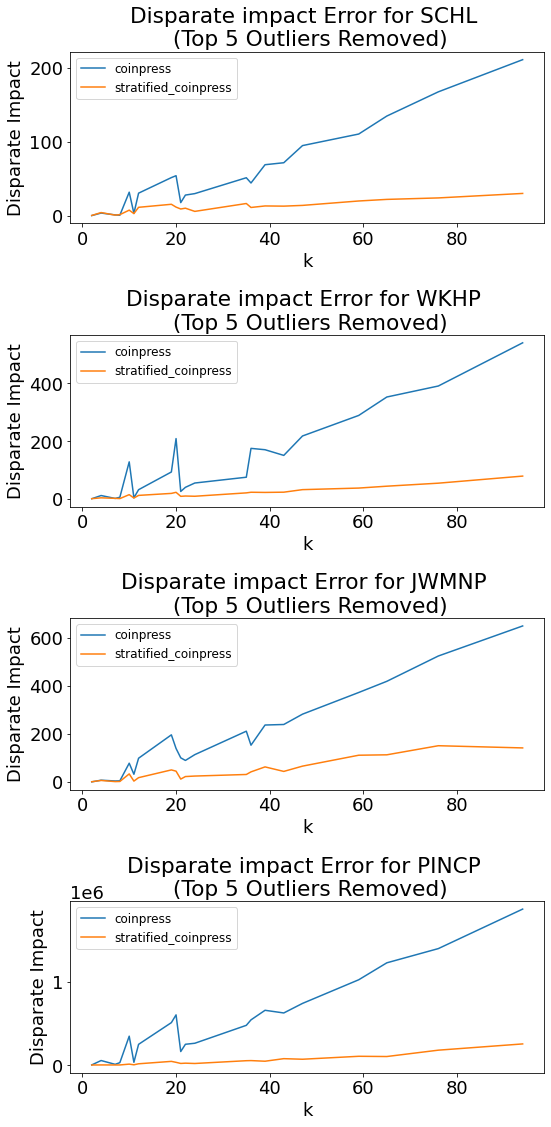

In [311]:
def remove_n_outliers(data, n):
    # Sort the data by error in descending order
    sorted_data = data.sort_values(by='error', ascending=False)
    
    # Remove the top n rows with the highest error
    filtered_data = sorted_data.iloc[n:]
    
    return filtered_data

# Set the number of outliers to remove
n_outliers = 5

# Group the data by column_name, size_of_combination, and mean_type, aggregating the error (summed) across stratum ids
grouped_error_data = error_df.groupby(['column_name', 'size_of_combination', 'mean_type'], group_keys=False).apply(lambda x: remove_n_outliers(x, n_outliers)).reset_index(drop=True)
grouped_error_data = grouped_error_data.groupby(['column_name', 'size_of_combination', 'mean_type']).agg({'error': 'sum'}).reset_index()

# Create a figure with subplots for each column_name
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 16))
axes = axes.flatten()

for i, column_name in enumerate(target_columns):
    ax = axes[i]
    sns.lineplot(data=grouped_error_data[grouped_error_data['column_name'] == column_name], 
                 x='size_of_combination', 
                 y='error', 
                 hue='mean_type', 
                 hue_order=['coinpress', 'stratified_coinpress'],
                 ax=ax)
    ax.set_title(f'Disparate impact Error for {column_name} \n (Top {n_outliers} Outliers Removed)')
    ax.set_ylabel('Disparate Impact')
    ax.set_xlabel('k')
    ax.legend(prop={'size': 12})

# increase font size
plt.rcParams.update({'font.size': 18})
# rename y axis

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

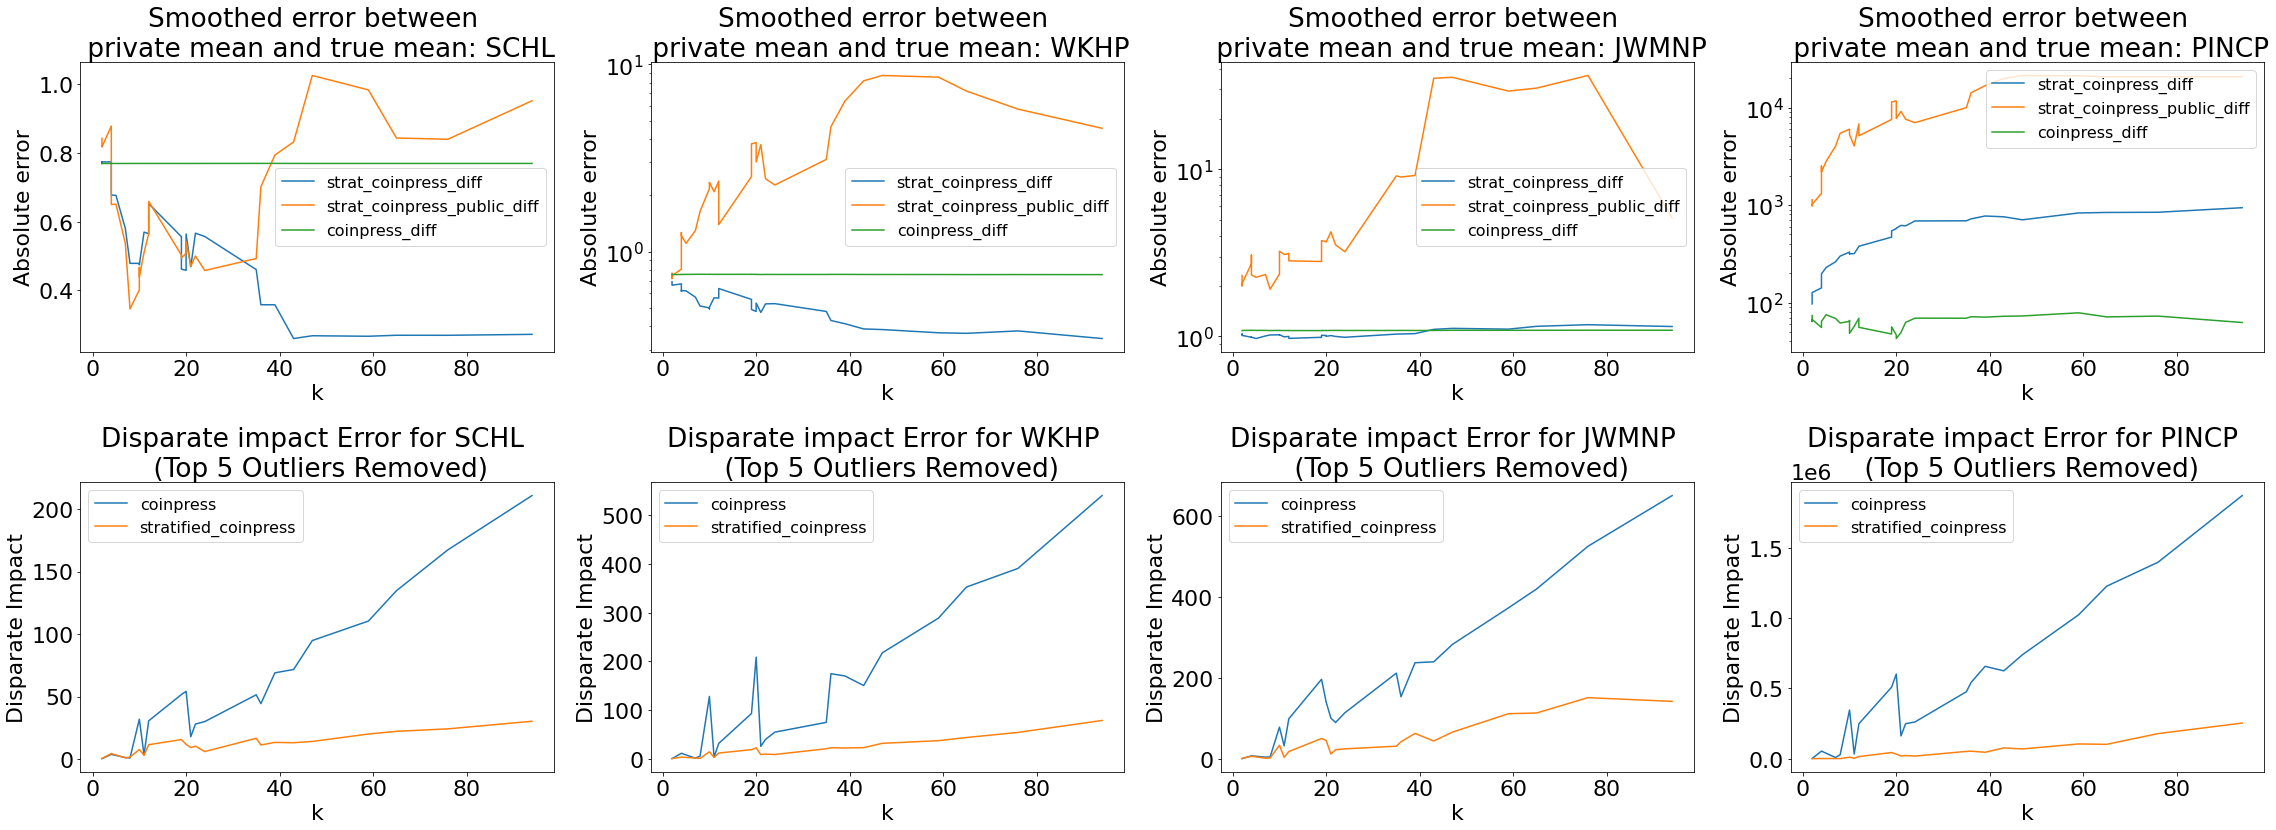

In [321]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of rows and columns for the subplots
nrows = 2
ncols = 4

# Create the subplots with the specified number of rows and columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(32, 12))

# First set of plots
for idx, target in enumerate(target_columns):
    ax = axes[0, idx]  # Update the axis indexing to use the first column

    grouped_data = res_df[res_df['column_name'] == target]
    grouped_data = grouped_data.sort_values(by=['size_of_combination'])
    window_size = 5

    # Calculate the rolling average
    grouped_data['strat_coinpress_diff'] = grouped_data['strat_coinpress_diff'].rolling(window=window_size, center=True, min_periods=1).mean()
    grouped_data['strat_coinpress_public_diff'] = grouped_data['strat_coinpress_public_diff'].rolling(window=window_size, center=True, min_periods=1).mean()
    grouped_data['coinpress_diff'] = grouped_data['coinpress_diff'].rolling(window=window_size, center=True, min_periods=1).mean()

    # Reset the index to make the 'x' column a regular column again
    grouped_data = grouped_data.reset_index()

    # Plot the data using the current axis
    grouped_data.plot(x='size_of_combination', y=['strat_coinpress_diff', 'strat_coinpress_public_diff', 'coinpress_diff'], kind='line', ax=ax)
    
    # Set log y scale
    if target != 'SCHL':
        ax.set_yscale('log')
    
    # Set plot title
    ax.set_title(f'Smoothed error between \n private mean and true mean: {target}')
    ax.set_xlabel('k')
    ax.set_ylabel('Absolute error')
    # rename legend
    ax.legend(['strat_coinpress', 'strat_coinpress_public', 'coinpress'])
    # shrink legend font
    ax.legend(prop={'size': 16})

# Second set of plots
for i, column_name in enumerate(target_columns):
    ax = axes[1, i]  # Update the axis indexing to use the second column
    sns.lineplot(data=grouped_error_data[grouped_error_data['column_name'] == column_name], 
                 x='size_of_combination', 
                 y='error', 
                 hue='mean_type', 
                 hue_order=['coinpress', 'stratified_coinpress'],
                 ax=ax)
    ax.set_title(f'Disparate impact Error for {column_name} \n (Top {n_outliers} Outliers Removed)')
    ax.set_ylabel('Disparate Impact')
    ax.set_xlabel('k')
    ax.legend(prop={'size': 16})

# Adjust the layout of the subplots
plt.tight_layout()
plt.rcParams.update({'font.size': 22})

# Show the plot
plt.show()